<a href="https://colab.research.google.com/github/larrychen20011120/NCKU-Quanta-Intern/blob/main/HMM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the library
* numpy: 數值運算
* random: 抽樣資料
* matplotlib: 繪製分析的圖形 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Sampling the series
判別隨機生成的數值位於那些數值區間

In [2]:
def sample_unit(prob_vec):
    sample_value = random.random()
    accumulator = 0
    for index, prob in enumerate(prob_vec):
        accumulator += prob
        if sample_value <= accumulator:
            return index

def sample_series(trans_matrix, emit_matrix, init_prob, series_len):
    current_state = sample_unit(init_prob)
    state_series = [ current_state ]
    observ_series = [ sample_unit(emit_matrix[current_state, :]) ]

    for _ in range(series_len-1):
        current_state = sample_unit(trans_matrix[current_state, :])
        state_series.append( current_state )
        observ_series.append( sample_unit(emit_matrix[current_state, :]) )
    return state_series, observ_series


## Viterbi Algorithm

In [52]:
def decode(A, B, PI, N, M, T, observs):
    
    # final result
    max_prob, guess_series = 0, np.zeros((T, ), dtype=np.int8)
    # defined matrix for dynamic programming
    psi = np.zeros((T, N))
    delta = np.zeros((T, N))
    scale = np.zeros((T, ))

    for t, observ in enumerate(observs):                # T times
        for state in range(N):                          # N times
            if t == 0: # initial
                delta[t, state] = PI[state] * B[state, observ]
            else:
                # dynamic programming
                inter_max = 0
                for inter_state in range(N):            # N times
                    value = delta[t-1, inter_state] * A[inter_state, state]
                    if value > inter_max:
                        inter_max = value
                        psi[t, state] = inter_state
                
                delta[t, state] = inter_max * B[state, observ] 
        # avoid scaling problem of delta
        scale[t] = np.sum(delta[t])
        delta[t] = delta[t] / scale[t]
            
    # collect the final result
    for state in range(N):
        if delta[T-1][state] > max_prob:
            max_prob, guess_series[T-1] = delta[T-1][state], state
    for t in range(T-1, 0, -1):
        guess_series[t-1] = psi[t, guess_series[t]]
    return guess_series

## Setting Parameters
範例測試資料以天氣和行為作為分析主題
* 3 種狀態和 3 種觀察值
* 觀察序列長度 T=15
* 狀態: **晴天**、**陰天**、**雨天**
* 觀察: **公園玩**、**逛街**、**待在家**

In [8]:
TIME_RANGE = 15
STATE_NUM = 3
OBSERV_NUM = 3
STATE_NAMES = ("Sunny", "Cloudy", "Rainy")
OBSERV_NAMES = ("Park", "Store", "Home")

trans_matrix = np.array([
    [0.7, 0.2, 0.1],
    [0.2, 0.4, 0.4],
    [0.15, 0.35, 0.5]
])
emit_matrix = np.array([
    [0.55, 0.25, 0.2],
    [0.4, 0.3, 0.3],
    [0.05, 0.25, 0.7]
])
init_prob = np.array([0.45, 0.35, 0.2])

## Analysis

### Generate the sample series

In [45]:
states, observs = sample_series(trans_matrix, emit_matrix, init_prob, TIME_RANGE)
print("States' Transition:")
for state in states:
    if state is not None:
        print(STATE_NAMES[state], end="  ")
print()
print()
print("Observations:")
for observ in observs:
    if observ is not None:
        print(OBSERV_NAMES[observ], end="  ")

States' Transition:
Rainy  Rainy  Sunny  Sunny  Sunny  Rainy  Rainy  Rainy  Cloudy  Rainy  Sunny  Sunny  Sunny  Rainy  Rainy  

Observations:
Store  Home  Park  Park  Home  Park  Store  Home  Home  Home  Home  Store  Home  Home  Home  

### Guess the most likely transistion

In [48]:
guess_series = decode(
    A=trans_matrix, B=emit_matrix, PI=init_prob,
    N=STATE_NUM, M=OBSERV_NUM, T=TIME_RANGE, observs=observs
)
print(guess_series)
print()
print("Guess States' Transition:")
for guess in guess_series:
    if guess is not None:
        print(STATE_NAMES[guess], end="  ")

[0.06185567 0.21649485 0.72164948]
[0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]

Guess States' Transition:
Sunny  Sunny  Sunny  Sunny  Sunny  Sunny  Cloudy  Rainy  Rainy  Rainy  Rainy  Rainy  Rainy  Rainy  Rainy  

### Calculate ACC

In [49]:
correct_count = 0
for t in range(TIME_RANGE):
    if guess_series[t] == states[t]:
        correct_count += 1
print(f"Accuracy: {correct_count / TIME_RANGE * 100:.2f}%")

Accuracy: 46.67%


### Repeat it 1000 times

In [53]:
corrects = []
for _ in range(1000):
    states, observs = sample_series(trans_matrix, emit_matrix, init_prob, TIME_RANGE)
    guess_series = decode(
        A=trans_matrix, B=emit_matrix, PI=init_prob,
        N=STATE_NUM, M=OBSERV_NUM, T=TIME_RANGE, observs=observs
    )
    
    correct_count = 0
    for t in range(TIME_RANGE):
        if guess_series[t] == states[t]:
            correct_count += 1
    corrects.append( correct_count / TIME_RANGE * 100)

51.41333333333333


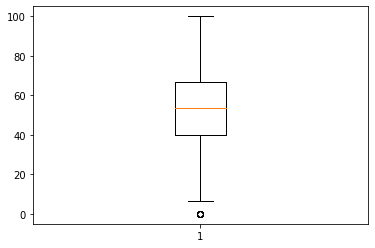

In [51]:
print(np.mean(corrects))
plt.boxplot(corrects)
plt.show()

## Compare different size and matrix types
* 觀察不同序列長度對準確度的影響
* 觀察不同數值的矩陣對準確度的影響

### Length of series
看起來隨序列長度增加，準確度會下降並收斂到某個值

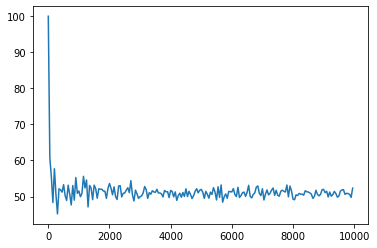

In [54]:
time_x = np.arange(1, 10000, 50)
acc_y = []
for x in time_x:
    
    states, observs = sample_series(trans_matrix, emit_matrix, init_prob, x)
    guess_series = decode(
        A=trans_matrix, B=emit_matrix, PI=init_prob,
        N=STATE_NUM, M=OBSERV_NUM, T=x, observs=observs
    )
    correct_count, acc = 0, 0
    for t in range(x):
        if guess_series[t] == states[t]:
            correct_count += 1
    acc = correct_count / x * 100
    acc_y.append(acc)

plt.plot(time_x, acc_y)
plt.show()

### Different Types
較確定的值和較隨機的值所構成的矩陣對準確度的影響

In [23]:
A1 = np.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.05, 0.85],
    [0.05, 0.9, 0.05]
])
B1 = np.array([
    [0.05, 0.85, 0.1],
    [0.15, 0.1, 0.75],
    [0.05, 0.2, 0.75]
])
A2 = np.array([
    [0.3, 0.3, 0.4],
    [0.4, 0.4, 0.2],
    [0.35, 0.35, 0.3]
])
B2 = np.array([
    [0.33, 0.33, 0.34],
    [0.4, 0.35, 0.25],
    [0.3, 0.4, 0.3]
])

AB_sets = (
    (A1, B1), (A2, B2), (A1, B2), (A2, B1)
)

在序列長度為 15 (較小時)，越準確的矩陣數值能有較高的準確度

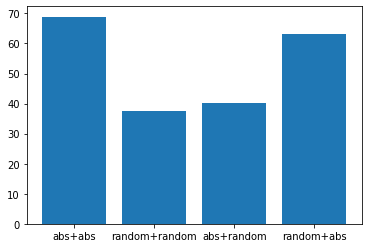

In [36]:
type_x = ['abs+abs', 'random+random', 'abs+random', 'random+abs']
acc_y = []
for A_mat, B_mat in AB_sets:
    acc = []
    for _ in range(1000):
        states, observs = sample_series(A_mat, B_mat, init_prob, TIME_RANGE)
        guess_series = decode(
            A=A_mat, B=B_mat, PI=init_prob,
            N=STATE_NUM, M=OBSERV_NUM, T=TIME_RANGE, observs=observs
        )
        correct_count = 0
        for t in range(TIME_RANGE):
            if guess_series[t] == states[t]:
                correct_count += 1
        acc.append(correct_count / TIME_RANGE * 100)
    acc_y.append(np.mean(acc))
plt.bar(type_x, acc_y)
plt.show()

* 無論矩陣值是多少，隨序列增長似乎都會收斂到約莫40%左右(??)
* 矩陣的值在序列短時，會有顯著的影響，通常越確定的值能產生越高的準確度
* 就趨勢而言，序列越長準確度會下降並收斂
* 要不然就是我程式寫錯了XD

<ipython-input-62-28b89248eba4>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


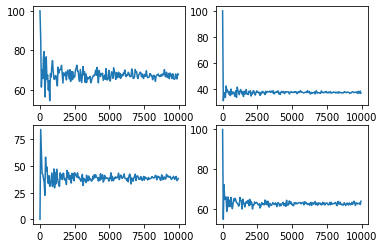

In [62]:
time_x = np.arange(1, 10000, 50)
acc_y = [[], [], [], []]
index = 0
for A_mat, B_mat in AB_sets:
    for x in time_x:
        
        states, observs = sample_series(A_mat, B_mat, init_prob, x)
        guess_series = decode(
            A=A_mat, B=B_mat, PI=init_prob,
            N=STATE_NUM, M=OBSERV_NUM, T=x, observs=observs
        )
        correct_count, acc = 0, 0
        for t in range(x):
            if guess_series[t] == states[t]:
                correct_count += 1
        acc = correct_count / x * 100
        acc_y[index].append(acc)
    index += 1
fig = plt.figure()
plt.ylim(-0.5, 100)
plt.subplot(221)
plt.plot(time_x, acc_y[0])
plt.subplot(222)
plt.plot(time_x, acc_y[1])
plt.subplot(223)
plt.plot(time_x, acc_y[2])
plt.subplot(224)
plt.plot(time_x, acc_y[3])
plt.show()

## Define error to find where maybe the scaling problems happened

In [88]:
def block_error(values, block_size=2):
    threshold = 5
    count = len(values) // block_size
    mean_values = []
    for i in range(count):
        mean_values.append(
            np.mean( values[i*block_size: (i+1)*block_size]) 
        )
    errors = np.abs(np.diff(np.array(mean_values)))
    print(errors)
    return np.where(errors > threshold) * np.array(block_size*50)

In [89]:
block_error(acc_y[0])

[27.34484785  5.29042579  3.17670796  2.74734123  4.26192977  4.18338864
  0.87347459  7.77275869  2.9431931   6.65018329  1.7828946   4.15149691
  6.94379863  0.22262057  1.31505886  5.73280692  2.50342305  0.22437957
  1.02958966  1.81407544  0.97397672  1.14196334  0.42526201  0.73517196
  1.91396785  3.38580458  2.33096932  4.59132366  3.87868345  3.0099903
  3.96260769  3.16152945  0.58928424  0.06452065  0.02959758  0.70399538
  0.04763915  1.89308635  0.43108688  1.17802424  0.85970237  2.84566545
  0.92069202  0.35532997  1.35970482  0.17921445  1.23175688  2.91787476
  2.72818561  2.878281    3.01671678  0.80046517  3.16846604  3.81948734
  0.96864033  0.59512239  0.78771692  0.88669821  1.01843189  0.93808663
  0.2364702   1.37458628  0.95222471  0.642611    0.81524826  3.07887514
  3.94739274  2.6109555   0.57017181  2.94487506  1.75109368  0.97941094
  1.46060029  1.34125291  1.46197432  0.78804306  1.74487166  0.16113677
  1.80036273  0.98046875  1.31445388  1.22670404  1.

array([[   0,  100,  700,  900, 1200, 1500]])